In [1]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

import warnings

In [2]:
sns.set(style='whitegrid', rc={'axes.facecolor': '#EFF2F7'})

settings = {}
settings['fs'] = 500

df = pd.read_csv("./ecg.csv", sep=";", index_col="ms")

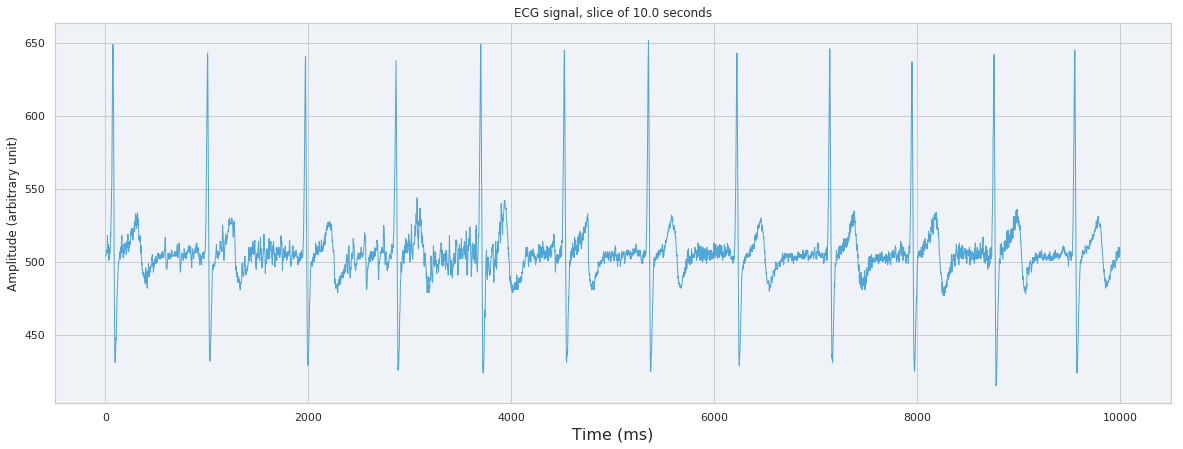

In [3]:
plt.figure(figsize=(20, 7))
start = 0
stop = 5000
duration = (stop-start) / settings['fs']
plt.title("ECG signal, slice of %.1f seconds" % duration)
plt.plot(df[start:stop].index, df[start:stop].heartrate, color="#51A6D8", linewidth=1)
plt.xlabel("Time (ms)", fontsize=16)
plt.ylabel("Amplitude (arbitrary unit)")
plt.show()

In [4]:
def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    if qrs_filter is None:
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    

    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    return ecg_signal[similarity > threshold].index, similarity


def get_plot_ranges(start=10, end=20, n=5):

    distance = end - start
    for i in np.arange(start, end, np.floor(distance/n)):
        yield (int(i), int(np.minimum(end, np.floor(distance/n) + i)))

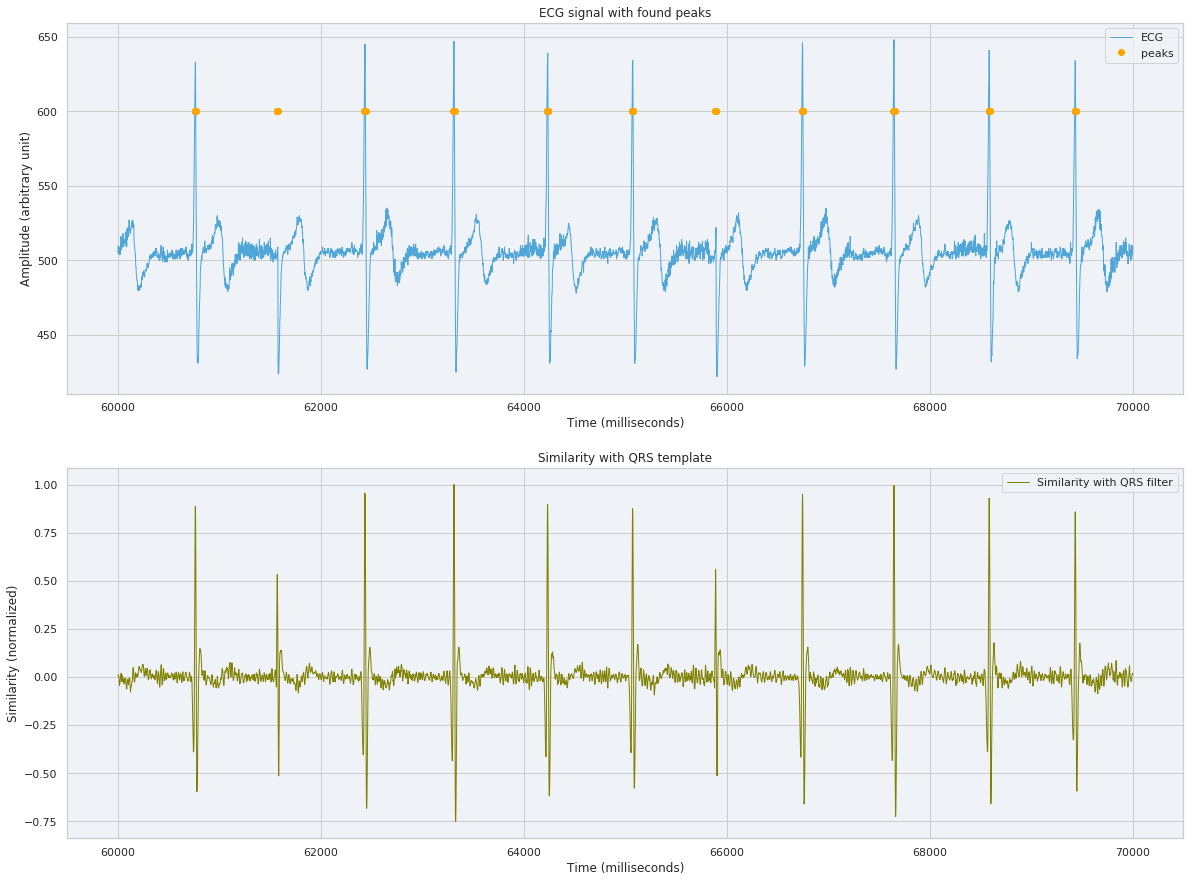

In [5]:
sampfrom = 60000
sampto = 70000
nr_plots = 1

for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):

    cond_slice = (df.index >= start) & (df.index < stop) 
    ecg_slice = df.heartrate[cond_slice]


    peaks, similarity = detect_peaks(ecg_slice, threshold=0.3)
    
    plt.figure(figsize=(20, 15))

    plt.subplot(211)
    plt.title("ECG signal with found peaks")
    plt.plot(ecg_slice.index, ecg_slice, label="ECG", color="#51A6D8", linewidth=1)
    plt.plot(peaks, np.repeat(600, peaks.shape[0]), label="peaks", color="orange", marker="o", linestyle="None")
    plt.legend(loc="upper right")
    plt.xlabel("Time (milliseconds)")
    plt.ylabel("Amplitude (arbitrary unit)")
    
    plt.subplot(212)
    plt.title('Similarity with QRS template')
    plt.plot(ecg_slice.index, similarity, label="Similarity with QRS filter", color="olive", linewidth=1)
    plt.legend(loc="upper right")
    plt.xlabel("Time (milliseconds)")
    plt.ylabel("Similarity (normalized)")
    

In [6]:
def group_peaks(p, threshold=5):
    output = np.empty(0)
    peak_groups, num_groups = label(np.diff(p) < threshold)
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output

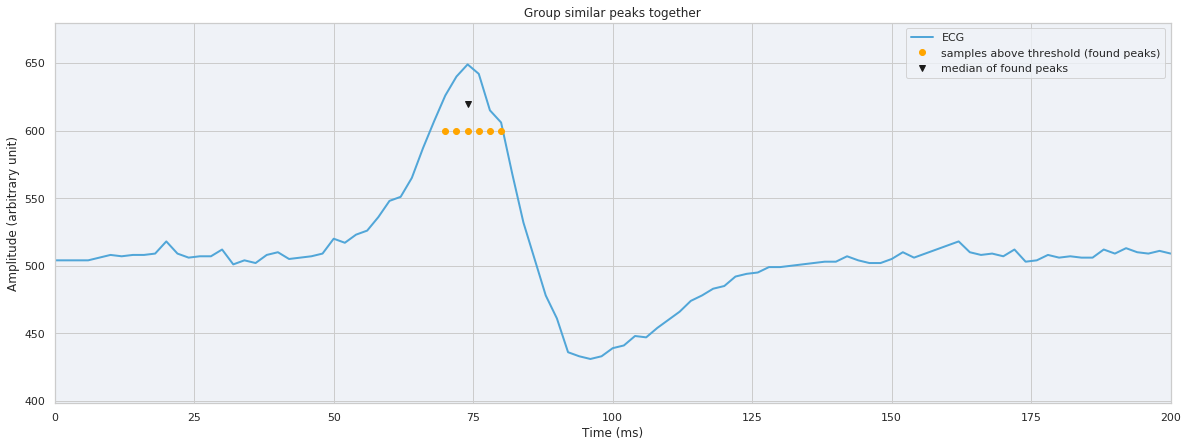

In [7]:

peaks, similarity = detect_peaks(df.heartrate, threshold=0.3)


grouped_peaks = group_peaks(peaks)


plt.figure(figsize=(20, 7))
plt.title("Group similar peaks together")
plt.plot(df.index, df.heartrate, label="ECG", color="#51A6D8", linewidth=2)
plt.plot(peaks, np.repeat(600, peaks.shape[0]),label="samples above threshold (found peaks)", color="orange", marker="o", linestyle="None")
plt.plot(grouped_peaks, np.repeat(620, grouped_peaks.shape[0]), label="median of found peaks", color="k", marker="v", linestyle="None")
plt.legend(loc="upper right")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude (arbitrary unit)")
plt.gca().set_xlim(0, 200)
plt.show()

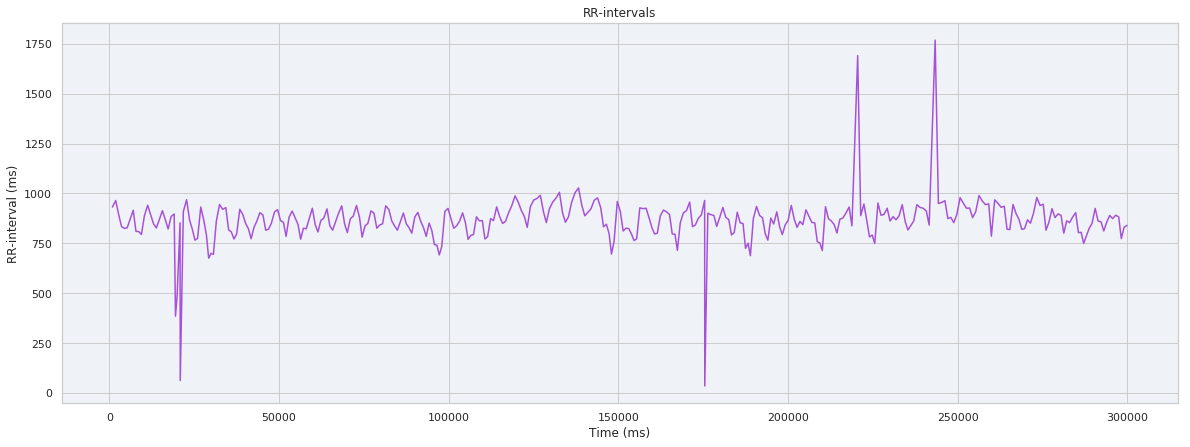

In [8]:

peaks, similarity = detect_peaks(df.heartrate, threshold=0.3)


grouped_peaks = group_peaks(peaks)

rr = np.diff(grouped_peaks)

plt.figure(figsize=(20, 7))
plt.title("RR-intervals")
plt.xlabel("Time (ms)")
plt.ylabel("RR-interval (ms)")

plt.plot(np.cumsum(rr), rr, label="RR-interval", color="#A651D8")
plt.show()

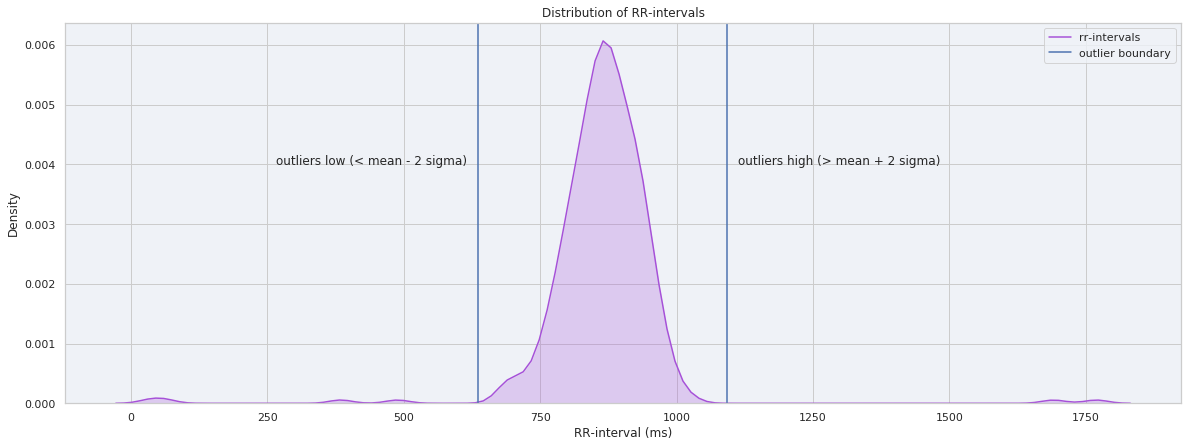

In [9]:
plt.figure(figsize=(20, 7))
plt.title("Distribution of RR-intervals")

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sns.kdeplot(rr, label="rr-intervals", color="#A651D8", shade=True)

outlier_low = np.mean(rr) - 2 * np.std(rr)
outlier_high = np.mean(rr) + 2 * np.std(rr)

plt.axvline(x=outlier_low)
plt.axvline(x=outlier_high, label="outlier boundary")
plt.text(outlier_low - 370, 0.004, "outliers low (< mean - 2 sigma)")
plt.text(outlier_high + 20, 0.004, "outliers high (> mean + 2 sigma)")

plt.xlabel("RR-interval (ms)")
plt.ylabel("Density")

plt.legend()
plt.show()

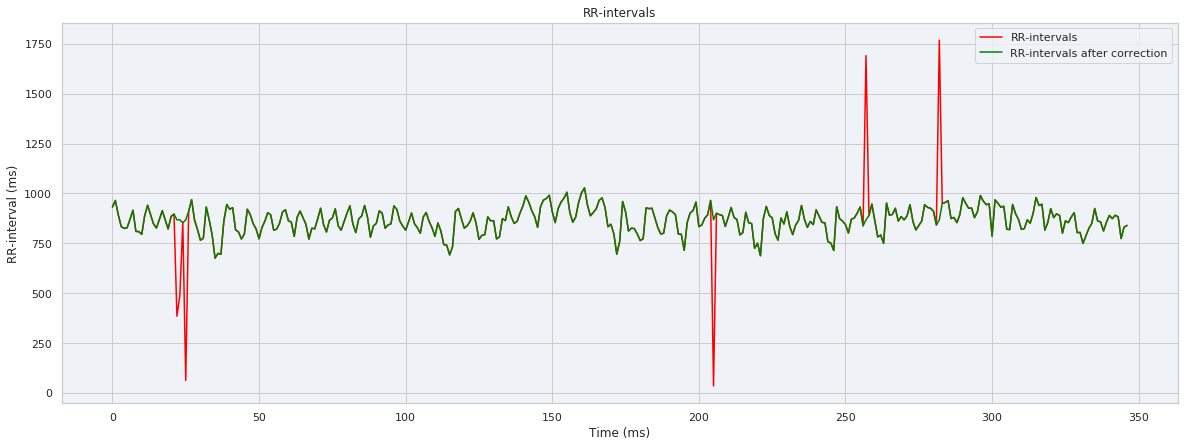

In [10]:
plt.figure(figsize=(20, 7))

rr_corrected = rr.copy()
rr_corrected[np.abs(zscore(rr)) > 2] = np.median(rr)

plt.title("RR-intervals")
plt.xlabel("Time (ms)")
plt.ylabel("RR-interval (ms)")

plt.plot(rr, color="red", label="RR-intervals")
plt.plot(rr_corrected, color="green",  label="RR-intervals after correction")
plt.legend()
plt.show()

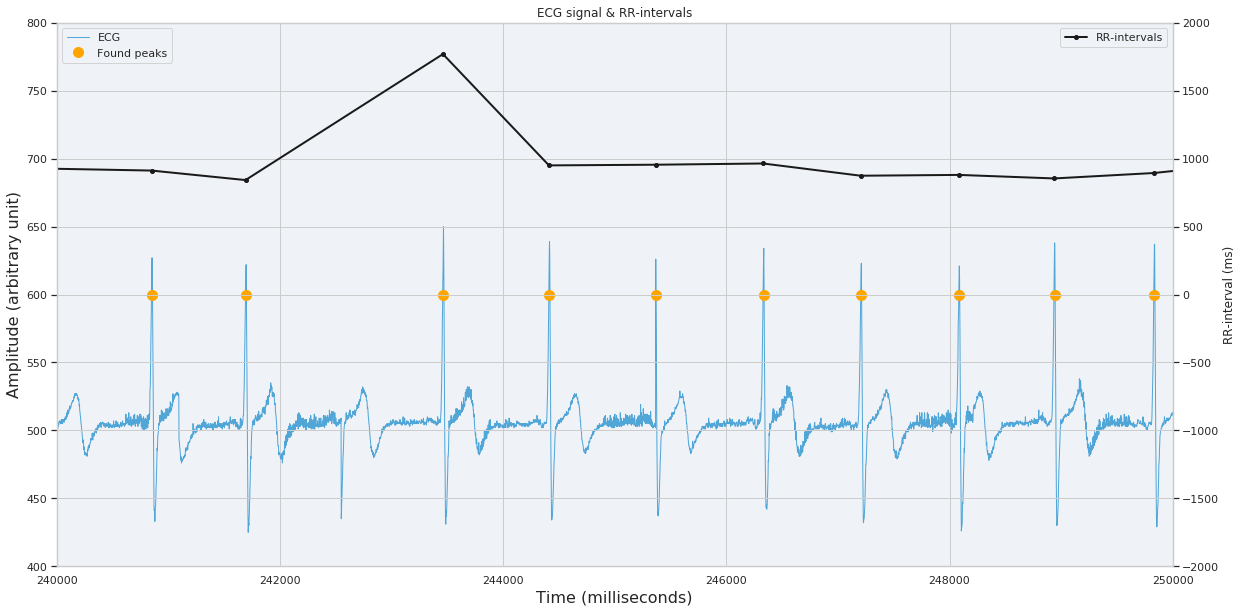

In [13]:
sampfrom = 240000
sampto = 250000
nr_plots = 1

peaks, similarity = detect_peaks(df.heartrate, threshold=0.3)

grouped_peaks = group_peaks(peaks)

rr = np.diff(grouped_peaks)

for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
    plt.figure(figsize=(20, 10))

    plt.title("ECG signal & RR-intervals")
    plt.plot(df.index, df.heartrate, label="ECG", color="#51A6D8", linewidth=1)
    plt.plot(grouped_peaks, np.repeat(600, grouped_peaks.shape[0]), markersize=10, label="Found peaks", color="orange", marker="o", linestyle="None")
    plt.legend(loc="upper left")
    plt.xlabel("Time (milliseconds)", fontsize=16)
    plt.ylabel("Amplitude (arbitrary unit)", fontsize=16)
    plt.gca().set_ylim(400, 800)
    
    ax2 = plt.gca().twinx()
    ax2.plot(np.cumsum(rr)+peaks[0], rr, label="RR-intervals", color="k", linewidth=2, marker=".", markersize=8)
    
    ax2.set_xlim(start, stop)
    ax2.set_ylim(-2000, 2000)
    ax2.legend(loc="upper right")
    plt.xlabel("Time (ms)")
    plt.ylabel("RR-interval (ms)")

In [14]:
def timedomain(rr):
    results = {}

    hr = 60000/rr
    
    results['Mean RR (ms)'] = np.mean(rr)
    results['STD RR/SDNN (ms)'] = np.std(rr)
    results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(rr)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
    results['NNxx'] = np.sum(np.abs(np.diff(rr)) > 50)*1
    results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    return results

print("Time domain metrics - automatically corrected RR-intervals:")
for k, v in timedomain(rr).items():
    print("- %s: %.2f" % (k, v))


Time domain metrics - automatically corrected RR-intervals:
- Mean RR (ms): 864.31
- STD RR/SDNN (ms): 114.49
- Mean HR (Kubios' style) (beats/min): 69.42
- Mean HR (beats/min): 77.11
- STD HR (beats/min): 100.24
- Min HR (beats/min): 33.92
- Max HR (beats/min): 1714.29
- RMSSD (ms): 147.30
- NNxx: 132.00
- pNNxx (%): 38.04


In [20]:
x = np.cumsum(rr) / 1000.0
f = interp1d(x, rr, kind='cubic')
fs = 4.0
steps = 1 / fs

xx = np.arange(1, np.max(x), steps)
rr_interpolated = f(xx)

In [23]:
def frequency_domain(rri, fs=4):
    fxx, pxx = signal.welch(x=rr_interpolated, fs=fs)

    cond_vlf = (fxx >= 0) & (fxx < 0.04)
    cond_lf = (fxx >= 0.04) & (fxx < 0.15)
    cond_hf = (fxx >= 0.15) & (fxx < 0.4)
    

    lf = trapz(pxx[cond_lf], fxx[cond_lf])
    vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
    hf = trapz(pxx[cond_hf], fxx[cond_hf])
    
    total_power = vlf + lf + hf
    peak_vlf = fxx[cond_vlf][np.argmax(pxx[cond_vlf])]
    peak_lf = fxx[cond_lf][np.argmax(pxx[cond_lf])]
    peak_hf = fxx[cond_hf][np.argmax(pxx[cond_hf])]

    lf_nu = 100 * lf / (lf + hf)
    hf_nu = 100 * hf / (lf + hf)
    
    results = {}
    results['Power VLF (ms2)'] = vlf
    results['Power LF (ms2)'] = lf
    results['Power HF (ms2)'] = hf   
    results['Power Total (ms2)'] = total_power

    results['LF/HF'] = (lf/hf)
    results['Peak VLF (Hz)'] = peak_vlf
    results['Peak LF (Hz)'] = peak_lf
    results['Peak HF (Hz)'] = peak_hf

    results['Fraction LF (nu)'] = lf_nu
    results['Fraction HF (nu)'] = hf_nu
    return results, fxx, pxx

In [24]:
print("Frequency domain metrics:")
results, fxx, pxx = frequency_domain(rr_interpolated)

for k, v in results.items():
    print("- %s: %.2f" % (k, v))

Frequency domain metrics:
- Power VLF (ms2): 890.57
- Power LF (ms2): 3334.27
- Power HF (ms2): 13359.53
- Power Total (ms2): 17584.37
- LF/HF: 0.25
- Peak VLF (Hz): 0.02
- Peak LF (Hz): 0.12
- Peak HF (Hz): 0.39
- Fraction LF (nu): 19.97
- Fraction HF (nu): 80.03


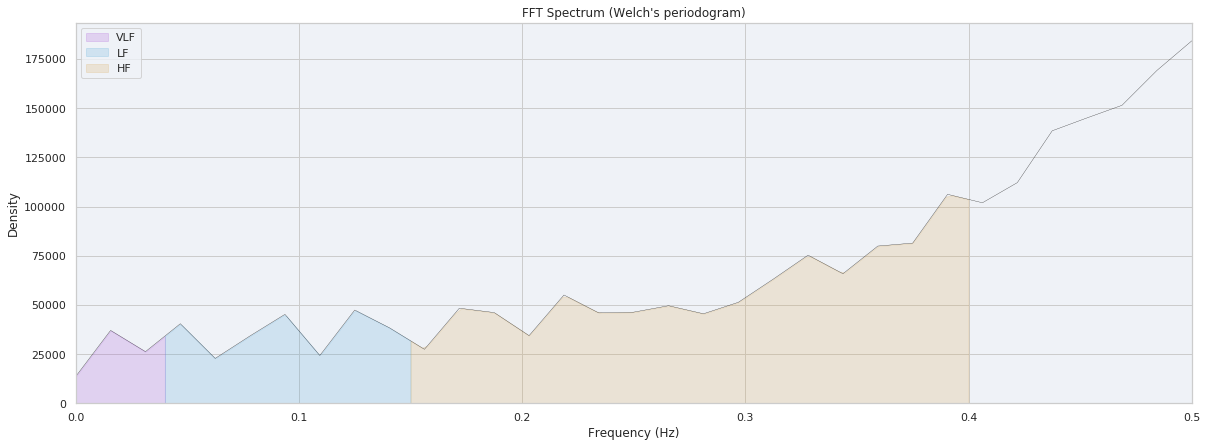

In [25]:
plt.figure(figsize=(20, 7))
plt.plot(fxx, pxx, color="k", linewidth=0.3)
plt.title("FFT Spectrum (Welch's periodogram)")
psd_f = interp1d(fxx, pxx)

x_vlf = np.linspace(0, 0.04, 100)
x_lf = np.linspace(0.04, 0.15, 100)
x_hf = np.linspace(0.15, 0.4, 100)

plt.gca().fill_between(x_vlf, psd_f(x_vlf), alpha=0.2, color="#A651D8", label="VLF")
plt.gca().fill_between(x_lf, psd_f(x_lf), alpha=0.2, color="#51A6D8", label="LF")
plt.gca().fill_between(x_hf, psd_f(x_hf), alpha=0.2, color="#D8A651", label="HF")

plt.gca().set_xlim(0, 0.5)
plt.gca().set_ylim(0)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Density")
plt.legend()
plt.show()

SD1: 104.158 ms
SD2: 124.209 ms


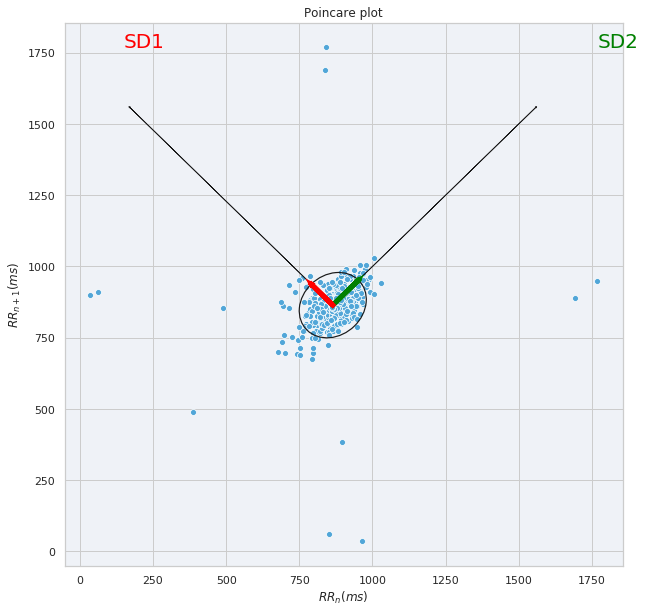

In [27]:
def plot_poincare(rr):
    rr_n = rr[:-1]
    rr_n1 = rr[1:]

    sd1 = np.sqrt(0.5) * np.std(rr_n1 - rr_n)
    sd2 = np.sqrt(0.5) * np.std(rr_n1 + rr_n)

    m = np.mean(rr)
    min_rr = np.min(rr)
    max_rr = np.max(rr)
    
    plt.figure(figsize=(10, 10))
    plt.title("Poincare plot")

    sns.scatterplot(x=rr_n, y=rr_n1, color="#51A6D8")

    plt.xlabel(r'$RR_n (ms)$')
    plt.ylabel(r'$RR_{n+1} (ms)$')

    e1 = Ellipse((m, m), 2*sd1, 2*sd2, angle=-45, linewidth=1.2, fill=False, color="k")
    plt.gca().add_patch(e1)

    plt.arrow(m, m, (max_rr-min_rr)*0.4, (max_rr-min_rr)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)
    plt.arrow(m, m, (min_rr-max_rr)*0.4, (max_rr-min_rr)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)

    plt.arrow(m, m, sd2 * np.sqrt(0.5), sd2 * np.sqrt(0.5), color="green", linewidth=5)
    plt.arrow(m, m, -sd1 * np.sqrt(0.5), sd1 * np.sqrt(0.5), color="red", linewidth=5)

    plt.text(max_rr, max_rr, "SD2", fontsize=20, color="green")
    plt.text(m-(max_rr-min_rr)*0.4-20, max_rr, "SD1", fontsize=20, color="red")
    
    return sd1, sd2

sd1, sd2 = plot_poincare(rr)
print("SD1: %.3f ms" % sd1)
print("SD2: %.3f ms" % sd2)